In [32]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [33]:
import gym
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
import optuna
# from tensorboardX import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(4, 64)
        self.relu = nn.ReLU()
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)

        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, 2)

    def forward(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advAverage = torch.mean(adv, dim=1, keepdim=True)
        Q = value + adv - advAverage

        return Q

    def forward_2(self, state):
        y = self.relu(self.fc1(state))
        value = self.relu(self.fc_value(y))
        adv = self.relu(self.fc_adv(y))

        value = self.value(value)
        adv = self.adv(adv)

        advMax = torch.max(adv, dim=1, keepdim=True).values
        Q = value + adv - advMax

        return Q

    def select_action(self, state):
        with torch.no_grad():
            Q = self.forward(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()

    def select_action_2(self, state):
        with torch.no_grad():
            Q = self.forward_2(state)
            action_index = torch.argmax(Q, dim=1)
        return action_index.item()


class Memory(object):
    def __init__(self, memory_size: int) -> None:
        self.memory_size = memory_size
        self.buffer = deque(maxlen=self.memory_size)

    def add(self, experience) -> None:
        self.buffer.append(experience)

    def size(self):
        return len(self.buffer)

    def sample(self, batch_size: int, continuous: bool = True):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if continuous:
            rand = random.randint(0, len(self.buffer) - batch_size)
            return [self.buffer[i] for i in range(rand, rand + batch_size)]
        else:
            indexes = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
            return [self.buffer[i] for i in indexes]

    def clear(self):
        self.buffer.clear()


Defining the environment

In [ ]:
env= gym.make('CartPole-v1')

Defining the training class

In [34]:
class Training:
    def __init__(self, environment,action_selection):
        self.environment = environment
        self.action_selection=action_selection

    def objective(self, trial):
        params = {
            'initial_epsilon': trial.suggest_loguniform('initial_epsilon', 0.1, 0.2),
            'lr': trial.suggest_loguniform('lr', 1e-5, 1e-4),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'replay_size': trial.suggest_categorical('replay_size', [50000, 75000, 100000]),
        }
        seed = 1
        episode_rewards = self.train(seed, params, break_at_threshold=True, action_selection=onlineQNetwork.select_action)
        return np.mean(episode_rewards)

    def train(self, seed, params, break_at_threshold=False, action_selection=None):
        if action_selection is None:
            action_selection = self.action_selection
        env = self.environment
        env.seed(seed)
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        # onlineQNetwork = QNetwork().to(device)
        targetQNetwork = QNetwork().to(device)
        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())
        optimizer = torch.optim.Adam(onlineQNetwork.parameters(), lr=params['lr'])

        GAMMA = 0.99
        EXPLORE = 20000
        INITIAL_EPSILON = params['initial_epsilon']
        FINAL_EPSILON = 0.0001
        REPLAY_MEMORY = params['replay_size']
        BATCH = params['batch_size']
        MAX_EPISODES = 500
        UPDATE_STEPS = 4

        memory_replay = Memory(REPLAY_MEMORY)

        epsilon = INITIAL_EPSILON
        learn_steps = 0
        begin_learn = False

        episode_rewards = []
        running_reward = -500
        counter = 0

        for epoch in range(MAX_EPISODES):
            state = env.reset()
            episode_reward = 0
            done = False
            while not done:
                p = random.random()
                if p < epsilon:
                    action = random.randint(0, 1)
                else:
                    tensor_state = torch.FloatTensor(state).unsqueeze(0).to(device)
                    action = action_selection(tensor_state)
                next_state, reward, done, _ = env.step(action)
                episode_reward += reward

                memory_replay.add((state, next_state, action, reward, done))

                if memory_replay.size() > 128:
                    if not begin_learn:
                        print('learn begin!')
                        begin_learn = True
                    learn_steps += 1
                    if learn_steps % UPDATE_STEPS == 0:
                        targetQNetwork.load_state_dict(onlineQNetwork.state_dict())

                    batch = memory_replay.sample(BATCH, False)
                    batch_state, batch_next_state, batch_action, batch_reward, batch_done = zip(*batch)

                    batch_state = torch.FloatTensor(batch_state).to(device)
                    batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                    batch_action = torch.FloatTensor(batch_action).unsqueeze(1).to(device)
                    batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                    batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                    with torch.no_grad():
                        onlineQ_next = onlineQNetwork(batch_next_state)
                        targetQ_next = targetQNetwork(batch_next_state)
                        online_max_action = torch.argmax(onlineQ_next, dim=1, keepdim=True)
                        y = batch_reward + (1 - batch_done) * GAMMA * targetQ_next.gather(1, online_max_action.long())

                    loss = F.mse_loss(onlineQNetwork(batch_state).gather(1, batch_action.long()), y)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    if epsilon > FINAL_EPSILON:
                        epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE

                state = next_state

            episode_rewards.append(episode_reward)

            running_reward = 0.05 * episode_reward + (1 - 0.05) * running_reward

            if running_reward > env.spec.reward_threshold:
                if counter < 1:
                    print("Environment Solved. Running Reward is now {}".format(running_reward))
                    counter += 1
                if break_at_threshold:
                    break

            if epoch % 100 == 0:
                print('Seed: {}, Epoch: {}\tMoving average score: {:.2f}\t'.format(seed, epoch, episode_reward))

        return episode_rewards

Tuning Hyperparameters

In [35]:

onlineQNetwork = QNetwork().to(device)

TrainType1=Training(env,onlineQNetwork.select_action)
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(lambda trial: TrainType1.objective(trial), n_trials=3)

# Print the best parameters found
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-04-04 09:23:57,431] A new study created in memory with name: no-name-88d9e740-1391-4d0a-8904-20e148602ca9


Seed: 1, Episode: 0	Moving average score: 18.00	
learn begin!


C:\Users\shivp\AppData\Local\Temp\ipykernel_9456\647776070.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'initial_epsilon': trial.suggest_loguniform('initial_epsilon', 0.1, 0.3),
C:\Users\shivp\AppData\Local\Temp\ipykernel_9456\647776070.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr': trial.suggest_loguniform('lr', 1e-5, 1e-4),


Seed: 1, Episode: 100	Moving average score: 11.00	
Seed: 1, Episode: 200	Moving average score: 13.00	
Seed: 1, Episode: 300	Moving average score: 9.00	
Seed: 1, Episode: 400	Moving average score: 9.00	
Seed: 1, Episode: 500	Moving average score: 12.00	
Seed: 1, Episode: 600	Moving average score: 9.00	
Seed: 1, Episode: 700	Moving average score: 10.00	
Seed: 1, Episode: 800	Moving average score: 10.00	
Seed: 1, Episode: 900	Moving average score: 10.00	
Seed: 1, Episode: 1000	Moving average score: 13.00	
Seed: 1, Episode: 1100	Moving average score: 14.00	
Seed: 1, Episode: 1200	Moving average score: 11.00	
Seed: 1, Episode: 1300	Moving average score: 15.00	
Seed: 1, Episode: 1400	Moving average score: 14.00	
Seed: 1, Episode: 1500	Moving average score: 10.00	
Seed: 1, Episode: 1600	Moving average score: 10.00	
Seed: 1, Episode: 1700	Moving average score: 12.00	
Seed: 1, Episode: 1800	Moving average score: 10.00	
Seed: 1, Episode: 1900	Moving average score: 11.00	


[I 2024-04-04 09:25:15,959] Trial 0 finished with value: 12.113 and parameters: {'initial_epsilon': 0.2716251839375287, 'lr': 1.0951266861131506e-05, 'batch_size': 32, 'replay_size': 100000}. Best is trial 0 with value: 12.113.


Seed: 1, Episode: 0	Moving average score: 10.00	
learn begin!
Seed: 1, Episode: 100	Moving average score: 11.00	
Seed: 1, Episode: 200	Moving average score: 143.00	
Seed: 1, Episode: 300	Moving average score: 187.00	
Seed: 1, Episode: 400	Moving average score: 236.00	
Seed: 1, Episode: 500	Moving average score: 461.00	
Seed: 1, Episode: 600	Moving average score: 176.00	
Seed: 1, Episode: 700	Moving average score: 500.00	


[I 2024-04-04 09:40:11,237] Trial 1 finished with value: 201.67152317880794 and parameters: {'initial_epsilon': 0.16758510311242736, 'lr': 8.052945322072001e-05, 'batch_size': 128, 'replay_size': 75000}. Best is trial 1 with value: 201.67152317880794.


Environmnt Solved. Running Reward is now 475.6480991817664
Seed: 1, Episode: 0	Moving average score: 10.00	
learn begin!
Seed: 1, Episode: 100	Moving average score: 9.00	
Seed: 1, Episode: 200	Moving average score: 9.00	
Seed: 1, Episode: 300	Moving average score: 13.00	
Seed: 1, Episode: 400	Moving average score: 11.00	
Seed: 1, Episode: 500	Moving average score: 30.00	
Seed: 1, Episode: 600	Moving average score: 37.00	
Seed: 1, Episode: 700	Moving average score: 85.00	
Seed: 1, Episode: 800	Moving average score: 144.00	
Seed: 1, Episode: 900	Moving average score: 141.00	
Seed: 1, Episode: 1000	Moving average score: 193.00	
Seed: 1, Episode: 1100	Moving average score: 163.00	
Seed: 1, Episode: 1200	Moving average score: 393.00	
Seed: 1, Episode: 1300	Moving average score: 481.00	


[I 2024-04-04 09:53:25,254] Trial 2 finished with value: 137.12014652014653 and parameters: {'initial_epsilon': 0.23823278084914615, 'lr': 3.8176320811519983e-05, 'batch_size': 32, 'replay_size': 50000}. Best is trial 1 with value: 201.67152317880794.


Environmnt Solved. Running Reward is now 475.92299400810583
Seed: 1, Episode: 0	Moving average score: 10.00	
learn begin!
Seed: 1, Episode: 100	Moving average score: 9.00	
Seed: 1, Episode: 200	Moving average score: 10.00	
Seed: 1, Episode: 300	Moving average score: 11.00	
Seed: 1, Episode: 400	Moving average score: 10.00	
Seed: 1, Episode: 500	Moving average score: 13.00	
Seed: 1, Episode: 600	Moving average score: 14.00	
Seed: 1, Episode: 700	Moving average score: 11.00	
Seed: 1, Episode: 800	Moving average score: 15.00	
Seed: 1, Episode: 900	Moving average score: 73.00	
Seed: 1, Episode: 1000	Moving average score: 154.00	
Seed: 1, Episode: 1100	Moving average score: 162.00	
Seed: 1, Episode: 1200	Moving average score: 188.00	
Seed: 1, Episode: 1300	Moving average score: 184.00	
Seed: 1, Episode: 1400	Moving average score: 169.00	
Seed: 1, Episode: 1500	Moving average score: 229.00	
Seed: 1, Episode: 1600	Moving average score: 137.00	
Seed: 1, Episode: 1700	Moving average score: 132.

[I 2024-04-04 10:10:37,072] Trial 3 finished with value: 100.8485 and parameters: {'initial_epsilon': 0.1336134662982348, 'lr': 2.5715305350644055e-05, 'batch_size': 64, 'replay_size': 75000}. Best is trial 1 with value: 201.67152317880794.


Seed: 1, Episode: 0	Moving average score: 10.00	
learn begin!
Seed: 1, Episode: 100	Moving average score: 10.00	
Seed: 1, Episode: 200	Moving average score: 12.00	
Seed: 1, Episode: 300	Moving average score: 12.00	
Seed: 1, Episode: 400	Moving average score: 110.00	
Seed: 1, Episode: 500	Moving average score: 207.00	
Seed: 1, Episode: 600	Moving average score: 153.00	
Seed: 1, Episode: 700	Moving average score: 197.00	
Seed: 1, Episode: 800	Moving average score: 195.00	
Seed: 1, Episode: 900	Moving average score: 287.00	
Seed: 1, Episode: 1000	Moving average score: 16.00	
Seed: 1, Episode: 1100	Moving average score: 127.00	
Seed: 1, Episode: 1200	Moving average score: 15.00	
Seed: 1, Episode: 1300	Moving average score: 25.00	


[I 2024-04-04 10:23:19,142] Trial 4 finished with value: 126.6137832017229 and parameters: {'initial_epsilon': 0.12379078556617465, 'lr': 7.744318573184429e-05, 'batch_size': 32, 'replay_size': 50000}. Best is trial 1 with value: 201.67152317880794.


Environmnt Solved. Running Reward is now 475.9857047253539
Best trial:
  Value:  201.67152317880794
  Params: 
    initial_epsilon: 0.16758510311242736
    lr: 8.052945322072001e-05
    batch_size: 128
    replay_size: 75000


Running the experiment 5 times and plotting

Seed: 0, Episode: 0	Moving average score: 23.00	
learn begin!
Seed: 0, Episode: 100	Moving average score: 13.00	
Seed: 0, Episode: 200	Moving average score: 204.00	
Seed: 0, Episode: 300	Moving average score: 345.00	
Seed: 0, Episode: 400	Moving average score: 344.00	
Seed: 0, Episode: 500	Moving average score: 97.00	
Seed: 0, Episode: 600	Moving average score: 500.00	
Environmnt Solved. Running Reward is now 475.72119371458626
Seed: 0, Episode: 700	Moving average score: 500.00	
Seed: 0, Episode: 800	Moving average score: 500.00	
Seed: 0, Episode: 900	Moving average score: 500.00	
Seed: 0, Episode: 1000	Moving average score: 500.00	
Seed: 0, Episode: 1100	Moving average score: 334.00	
Seed: 0, Episode: 1200	Moving average score: 500.00	
Seed: 0, Episode: 1300	Moving average score: 500.00	
Seed: 0, Episode: 1400	Moving average score: 215.00	
Seed: 0, Episode: 1500	Moving average score: 500.00	
Seed: 0, Episode: 1600	Moving average score: 500.00	
Seed: 0, Episode: 1700	Moving average sco

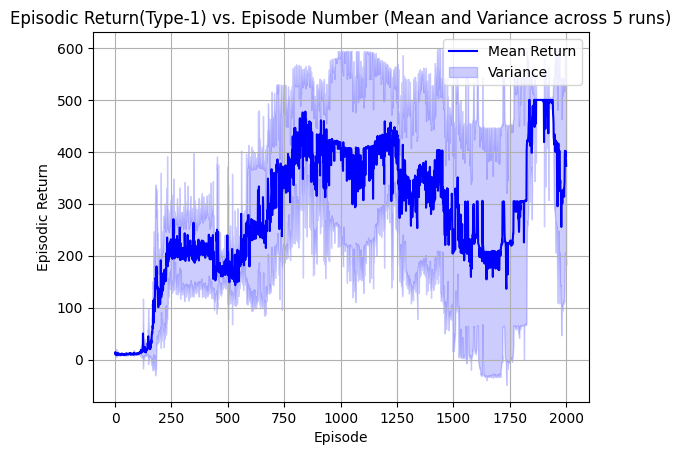

2000


In [36]:
num_seeds = 5
all_episode_rewards = []

for seed in range(num_seeds):
    episode_rewards = TrainType1.train(seed,trial.params)
    all_episode_rewards.append(episode_rewards)

# Calculate mean and variance across runs for each episode
mean_rewards_1 = np.mean(all_episode_rewards, axis=0)
variance_rewards_1 = np.var(all_episode_rewards, axis=0)


## Type 2 DQN


Tuning Hyperparamters

In [39]:

TrainType2=Training(env,onlineQNetwork.select_action_2)
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(lambda trial: TrainType2.objective(trial), n_trials=3)

# Print the best parameters found
print("Best trial:")
trial2 = study.best_trial
print("  Value: ", trial2.value)
print("  Params: ")
for key, value in trial2.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-04 15:48:47,835] A new study created in memory with name: no-name-f44e2bbd-b968-4026-9139-c620d69b181f


Seed: 1, Epoch: 0	Moving average score: 18.00	
learn begin!


C:\Users\shivp\AppData\Local\Temp\ipykernel_9456\1047964407.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'initial_epsilon': trial.suggest_loguniform('initial_epsilon', 0.1, 0.3),
C:\Users\shivp\AppData\Local\Temp\ipykernel_9456\1047964407.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lr': trial.suggest_loguniform('lr', 1e-5, 1e-4),


Seed: 1, Epoch: 100	Moving average score: 9.00	
Seed: 1, Epoch: 200	Moving average score: 9.00	
Seed: 1, Epoch: 300	Moving average score: 16.00	
Seed: 1, Epoch: 400	Moving average score: 16.00	
Seed: 1, Epoch: 500	Moving average score: 47.00	
Seed: 1, Epoch: 600	Moving average score: 39.00	
Seed: 1, Epoch: 700	Moving average score: 145.00	
Seed: 1, Epoch: 800	Moving average score: 140.00	
Seed: 1, Epoch: 900	Moving average score: 140.00	
Seed: 1, Epoch: 1000	Moving average score: 166.00	
Seed: 1, Epoch: 1100	Moving average score: 157.00	
Seed: 1, Epoch: 1200	Moving average score: 246.00	
Seed: 1, Epoch: 1300	Moving average score: 303.00	
Seed: 1, Epoch: 1400	Moving average score: 466.00	


[I 2024-04-04 16:05:47,797] Trial 0 finished with value: 139.92271505376345 and parameters: {'initial_epsilon': 0.29583204915971384, 'lr': 3.121045680068917e-05, 'batch_size': 64, 'replay_size': 50000}. Best is trial 0 with value: 139.92271505376345.


Environmnt Solved. Running Reward is now 475.62578764339486
Seed: 1, Epoch: 0	Moving average score: 10.00	
learn begin!
Seed: 1, Epoch: 100	Moving average score: 11.00	
Seed: 1, Epoch: 200	Moving average score: 9.00	
Seed: 1, Epoch: 300	Moving average score: 10.00	
Seed: 1, Epoch: 400	Moving average score: 10.00	
Seed: 1, Epoch: 500	Moving average score: 15.00	
Seed: 1, Epoch: 600	Moving average score: 12.00	
Seed: 1, Epoch: 700	Moving average score: 10.00	
Seed: 1, Epoch: 800	Moving average score: 17.00	
Seed: 1, Epoch: 900	Moving average score: 50.00	
Seed: 1, Epoch: 1000	Moving average score: 113.00	
Seed: 1, Epoch: 1100	Moving average score: 138.00	
Seed: 1, Epoch: 1200	Moving average score: 170.00	
Seed: 1, Epoch: 1300	Moving average score: 200.00	
Seed: 1, Epoch: 1400	Moving average score: 283.00	
Seed: 1, Epoch: 1500	Moving average score: 357.00	
Seed: 1, Epoch: 1600	Moving average score: 173.00	
Seed: 1, Epoch: 1700	Moving average score: 500.00	
Seed: 1, Epoch: 1800	Moving aver

[I 2024-04-04 16:26:30,804] Trial 1 finished with value: 145.2710779082177 and parameters: {'initial_epsilon': 0.1374091586543872, 'lr': 3.077690786239081e-05, 'batch_size': 32, 'replay_size': 50000}. Best is trial 1 with value: 145.2710779082177.


Environmnt Solved. Running Reward is now 475.85792152429815
Seed: 1, Epoch: 0	Moving average score: 10.00	
learn begin!
Seed: 1, Epoch: 100	Moving average score: 9.00	
Seed: 1, Epoch: 200	Moving average score: 9.00	
Seed: 1, Epoch: 300	Moving average score: 9.00	
Seed: 1, Epoch: 400	Moving average score: 9.00	
Seed: 1, Epoch: 500	Moving average score: 10.00	
Seed: 1, Epoch: 600	Moving average score: 8.00	
Seed: 1, Epoch: 700	Moving average score: 10.00	
Seed: 1, Epoch: 800	Moving average score: 10.00	
Seed: 1, Epoch: 900	Moving average score: 9.00	
Seed: 1, Epoch: 1000	Moving average score: 11.00	
Seed: 1, Epoch: 1100	Moving average score: 9.00	
Seed: 1, Epoch: 1200	Moving average score: 13.00	
Seed: 1, Epoch: 1300	Moving average score: 106.00	
Seed: 1, Epoch: 1400	Moving average score: 15.00	
Seed: 1, Epoch: 1500	Moving average score: 10.00	
Seed: 1, Epoch: 1600	Moving average score: 8.00	
Seed: 1, Epoch: 1700	Moving average score: 9.00	
Seed: 1, Epoch: 1800	Moving average score: 8.00

[I 2024-04-04 16:27:43,707] Trial 2 finished with value: 10.9985 and parameters: {'initial_epsilon': 0.11548090704520282, 'lr': 1.3015398602359471e-05, 'batch_size': 32, 'replay_size': 100000}. Best is trial 1 with value: 145.2710779082177.


Seed: 1, Epoch: 0	Moving average score: 10.00	
learn begin!
Seed: 1, Epoch: 100	Moving average score: 11.00	
Seed: 1, Epoch: 200	Moving average score: 11.00	
Seed: 1, Epoch: 300	Moving average score: 9.00	
Seed: 1, Epoch: 400	Moving average score: 9.00	
Seed: 1, Epoch: 500	Moving average score: 12.00	
Seed: 1, Epoch: 600	Moving average score: 11.00	
Seed: 1, Epoch: 700	Moving average score: 15.00	
Seed: 1, Epoch: 800	Moving average score: 12.00	
Seed: 1, Epoch: 900	Moving average score: 16.00	
Seed: 1, Epoch: 1000	Moving average score: 13.00	
Seed: 1, Epoch: 1100	Moving average score: 12.00	
Seed: 1, Epoch: 1200	Moving average score: 9.00	
Seed: 1, Epoch: 1300	Moving average score: 8.00	
Seed: 1, Epoch: 1400	Moving average score: 10.00	
Seed: 1, Epoch: 1500	Moving average score: 10.00	
Seed: 1, Epoch: 1600	Moving average score: 42.00	
Seed: 1, Epoch: 1700	Moving average score: 45.00	
Seed: 1, Epoch: 1800	Moving average score: 61.00	
Seed: 1, Epoch: 1900	Moving average score: 62.00	


[I 2024-04-04 16:30:37,823] Trial 3 finished with value: 21.259 and parameters: {'initial_epsilon': 0.20576069666033023, 'lr': 1.2863562094428047e-05, 'batch_size': 64, 'replay_size': 100000}. Best is trial 1 with value: 145.2710779082177.


Best trial:
  Value:  145.2710779082177
  Params: 
    initial_epsilon: 0.1374091586543872
    lr: 3.077690786239081e-05
    batch_size: 32
    replay_size: 50000


Seed: 0, Epoch: 0	Moving average score: 23.00	
learn begin!
Seed: 0, Epoch: 100	Moving average score: 11.00	
Seed: 0, Epoch: 200	Moving average score: 9.00	
Seed: 0, Epoch: 300	Moving average score: 11.00	
Seed: 0, Epoch: 400	Moving average score: 11.00	
Seed: 0, Epoch: 500	Moving average score: 16.00	
Seed: 0, Epoch: 600	Moving average score: 14.00	
Seed: 0, Epoch: 700	Moving average score: 12.00	
Seed: 0, Epoch: 800	Moving average score: 50.00	
Seed: 0, Epoch: 900	Moving average score: 29.00	
Seed: 0, Epoch: 1000	Moving average score: 87.00	
Seed: 0, Epoch: 1100	Moving average score: 144.00	
Seed: 0, Epoch: 1200	Moving average score: 205.00	
Seed: 0, Epoch: 1300	Moving average score: 197.00	
Seed: 0, Epoch: 1400	Moving average score: 188.00	
Seed: 0, Epoch: 1500	Moving average score: 452.00	
Seed: 0, Epoch: 1600	Moving average score: 500.00	
Environmnt Solved. Running Reward is now 475.9290770630934
Seed: 0, Epoch: 1700	Moving average score: 500.00	
Seed: 0, Epoch: 1800	Moving averag

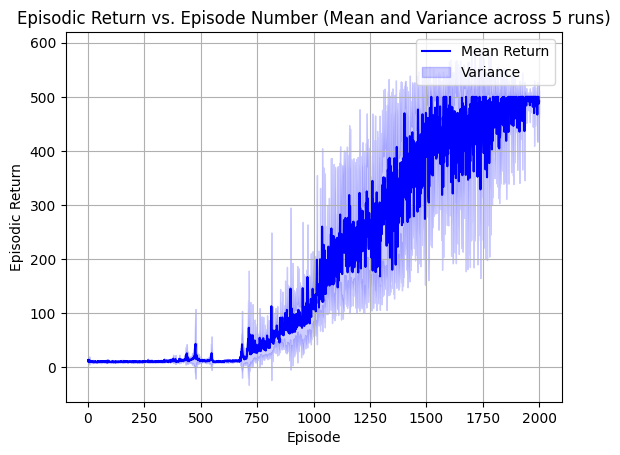

In [41]:
num_seeds = 5
all_episode_rewards_2 = []


for seed in range(num_seeds):
    episode_rewards = TrainType2.train(seed,trial2.params)
    all_episode_rewards_2.append(episode_rewards)

# Calculate mean and variance across runs for each episode
mean_rewards_2 = np.mean(all_episode_rewards_2, axis=0)
variance_rewards_2 = np.var(all_episode_rewards_2, axis=0)



Plotting both the types on the same graph

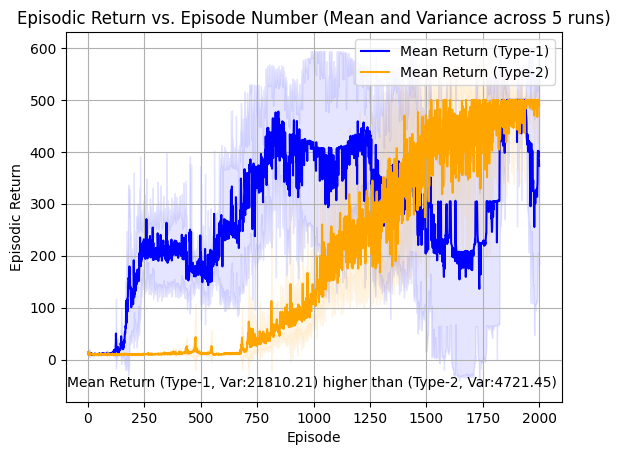

In [3]:
import matplotlib.pyplot as plt
import numpy as np
mean_rewards_1 = np.mean(all_episode_rewards, axis=0)
variance_rewards_1 = np.var(all_episode_rewards, axis=0)

mean_rewards_2 = np.mean(all_episode_rewards_2, axis=0)
variance_rewards_2 = np.var(all_episode_rewards_2, axis=0)

overall_variance_1 = np.mean(variance_rewards_1)
overall_variance_2 = np.mean(variance_rewards_2)

if overall_variance_1 > overall_variance_2:
    higher_variance_label = 'Mean Return (Type-1, Var:{:.2f}) higher than (Type-2, Var:{:.2f}) '.format(overall_variance_1,overall_variance_2)
elif overall_variance_1 < overall_variance_2:
    higher_variance_label = 'Mean Return (Type-2) has higher variance (Variance: {:.2f})'.format(overall_variance_2)
else:
    higher_variance_label = 'Both sets have the same variance (Variance: {:.2f})'.format(overall_variance_1)


# Plot mean episodic return with shaded regions representing variance for variant 1
plt.plot(range(1, len(mean_rewards_1) + 1), mean_rewards_1, label='Mean Return (Type-1)', color='blue')
plt.fill_between(range(1, len(mean_rewards_1) + 1), mean_rewards_1 - np.sqrt(variance_rewards_1),
                 mean_rewards_1 + np.sqrt(variance_rewards_1), color='blue', alpha=0.1)

# Plot mean episodic return with shaded regions representing variance for variant 2
plt.plot(range(1, len(mean_rewards_2) + 1), mean_rewards_2, label='Mean Return (Type-2)', color='orange')
plt.fill_between(range(1, len(mean_rewards_2) + 1), mean_rewards_2 - np.sqrt(variance_rewards_2),
                 mean_rewards_2 + np.sqrt(variance_rewards_2), color='orange', alpha=0.1)

plt.text(0.5, 0.05, higher_variance_label, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)


plt.xlabel('Episode')
plt.ylabel('Episodic Return')
plt.title('Episodic Return vs. Episode Number (Mean and Variance across 5 runs)')
plt.legend()
plt.grid(True)
plt.show()

Plotting Moving Average for last 100 episodes

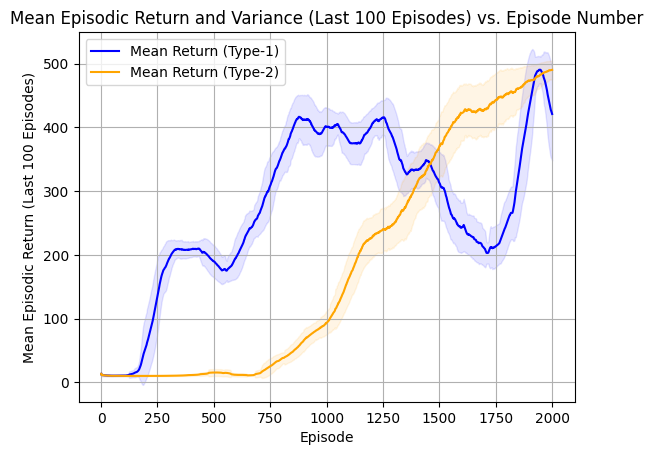

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to calculate mean average and variance for last 100 episodes
def calculate_last_100_stats(data):
    last_100_mean = np.mean(data[-100:])
    last_100_var = np.var(data[-100:])
    return last_100_mean, last_100_var

# Initialize lists to hold mean rewards and variances for both types
mean_rewards_1_last_100 = []
variance_rewards_1_last_100 = []
mean_rewards_2_last_100 = []
variance_rewards_2_last_100 = []

# Iterate over episodes
for episode in range(1, len(mean_rewards_1) + 1):
    # Calculate mean average and variance for last 100 episodes for both types
    mean_1_last_100, var_1_last_100 = calculate_last_100_stats(mean_rewards_1[:episode])
    mean_2_last_100, var_2_last_100 = calculate_last_100_stats(mean_rewards_2[:episode])
    
    # Append to lists
    mean_rewards_1_last_100.append(mean_1_last_100)
    variance_rewards_1_last_100.append(var_1_last_100)
    mean_rewards_2_last_100.append(mean_2_last_100)
    variance_rewards_2_last_100.append(var_2_last_100)

# Plot mean average and variance for last 100 episodes
plt.plot(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100, label='Mean Return (Type-1)', color='blue')
plt.fill_between(range(1, len(mean_rewards_1_last_100) + 1), mean_rewards_1_last_100 - np.sqrt(variance_rewards_1_last_100),
                 mean_rewards_1_last_100 + np.sqrt(variance_rewards_1_last_100), color='blue', alpha=0.1)

plt.plot(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100, label='Mean Return (Type-2)', color='orange')
plt.fill_between(range(1, len(mean_rewards_2_last_100) + 1), mean_rewards_2_last_100 - np.sqrt(variance_rewards_2_last_100),
                 mean_rewards_2_last_100 + np.sqrt(variance_rewards_2_last_100), color='orange', alpha=0.1)

plt.xlabel('Episode')
plt.ylabel('Mean Episodic Return (Last 100 Episodes)')
plt.title('Mean Episodic Return and Variance (Last 100 Episodes) vs. Episode Number')
plt.legend()
plt.grid(True)
plt.show()
